# Training textual modality


In [1]:
from datetime import datetime

import numpy as np

import os

import pandas as pd

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from time import time, gmtime, strftime

from bert.tokenization.bert_tokenization import FullTokenizer

from utils.models.modelUtils import calcAccTextModel

from final_models import create_text_model

from utils.callbacks.MyCallbacks import MyCallbacks

from utils.telegramUtils.telegram_bot import telegram_send_message

from utils.callbacks.callbackUtils import plotTimesPerEpoch

from utils.fileDirUtils.fileDirUtils import createDirIfNotExists

from sklearn.metrics import accuracy_score


In [2]:
#Verbose settings:
verbose = False
TF_VERBOSE = 1 # 1 = Progress bar 2 = one line per epoch only!
TF_DETERMINISTIC_OPS = 1 # Makes everything also on GPU deterministic

# Classes:
NUM_CLASS = 2  # FAKE | NO FAKE

# Hyperparameters
GLOBAL_BATCH_SIZE = 64
EPOCHS = 10

# Optimizer parameters:
# Adam
LEARNING_RATE = 1e-5
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8

#optimizers:

optimizer = Adam(LEARNING_RATE)

# Bert Parameters
MAX_SEQUENCE_LENGTH = 32 



In [3]:
# Path settings
root = '/home/armin/repos/fkd-model-handling/'

bert_model_dir = os.path.join(root, 'multi_cased_L-12_H-768_A-12')
pathToBertVocabFile = os.path.join(bert_model_dir, "vocab.txt")
bert_ckpt_file = os.path.join(bert_model_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_dir, "bert_config.json")

pathToTextLabelFiles = '/home/armin/repos/FKD-Dataset/008_text_image_meta_label/'

trainTextFile = os.path.join(pathToTextLabelFiles, "train_text_image_meta_label.csv")
testTextFile = os.path.join(pathToTextLabelFiles, "test_text_image_meta_label.csv")
valTextFile = os.path.join(pathToTextLabelFiles, "val_text_image_meta_label.csv")

checkpointDir = '/home/armin/repos/FKD-Dataset/011_checkpoints/'

In [4]:
# Other settings:

# Time settings:
current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")

#Checkpoint settings:
checkpoint_name = f'bert_only_{MAX_SEQUENCE_LENGTH}'

checkpointDir = os.path.join(checkpointDir, (checkpoint_name + '_' + current_time))

fileName="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filePath = os.path.join(checkpointDir, fileName)

In [5]:
df_train = pd.read_csv(trainTextFile, header=0, sep='\t')
df_test = pd.read_csv(testTextFile, header=0, sep='\t')
df_val = pd.read_csv(valTextFile, header=0, sep='\t')

In [6]:
# umbauen


from tqdm import tqdm
import pandas as pd
import numpy as np


class FakeDetectionDataTrainVal:
    DATA_COLUMN = "clean_title"
    LABEL_COLUMN = "2_way_label"

    def __init__(self, train, val, tokenizer, classes, max_seq_len=512):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len # vorher 0 
        self.classes = classes
        self.max_seq_length = 0

        ((self.train_x, self.train_y), (self.val_x, self.val_y)) = map(self._prepare, [train, val])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x = map(self._pad, [self.train_x, self.val_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
#             print(row)
            text, label = row[FakeDetectionDataTrainVal.DATA_COLUMN], row[FakeDetectionDataTrainVal.LABEL_COLUMN]
            label = int(label)
            tokens = self.tokenizer.tokenize(str(text)) # Achtung str hinzugefügt
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            
            if self.max_seq_length < self.max_seq_len:
                self.max_seq_length = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            x.append(np.array(input_ids))
        return np.array(x)
    
    def getMaxSeqLength(self):
        return self.max_seq_length

   
class FakeDetectionDataTest:
    DATA_COLUMN = "clean_title"
    LABEL_COLUMN = "2_way_label"

    def __init__(self, test, tokenizer, classes, max_seq_len=512):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.classes = classes

        (self.test_x, self.test_y) = self._prepare(test)

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.test_x = self._pad(self.test_x)

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
#             print(row)
            text, label = row[FakeDetectionDataTest.DATA_COLUMN], row[FakeDetectionDataTest.LABEL_COLUMN]
            label = int(label)
            tokens = self.tokenizer.tokenize(str(text)) # Achtung str hinzugefügt
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            x.append(np.array(input_ids))
        return np.array(x)


In [7]:
# umbauen


from tqdm import tqdm
import pandas as pd
import numpy as np


class FakeDetectionDataCommentsTrainVal:
    DATA_COLUMN = "comments"
    LABEL_COLUMN = "2_way_label"

    def __init__(self, train, val, tokenizer, classes, max_seq_len=512):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len # vorher 0 
        self.classes = classes
        self.max_seq_length = 0

        ((self.train_x, self.train_y), (self.val_x, self.val_y)) = map(self._prepare, [train, val])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x = map(self._pad, [self.train_x, self.val_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
#             print(row)
            text, label = row[FakeDetectionDataCommentsTrainVal.DATA_COLUMN], row[FakeDetectionDataCommentsTrainVal.LABEL_COLUMN]
            label = int(label)
            text = str(text).replace('[', '').replace(']', '').replace("'", '')
            tokens = self.tokenizer.tokenize(str(text)) # Achtung str hinzugefügt
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            
            if self.max_seq_length < self.max_seq_len:
                self.max_seq_length = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
#             input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
#             input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)
    
    def getMaxSeqLength(self):
        return self.max_seq_length


class FakeDetectionDataCommentsTest:
    DATA_COLUMN = "comments"
    LABEL_COLUMN = "2_way_label"

    def __init__(self, test, tokenizer, classes, max_seq_len=512):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.classes = classes

        (self.test_x, self.test_y) = self._prepare(test)

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.test_x = self._pad(self.test_x)

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
#             print(row)
            text, label = row[FakeDetectionDataCommentsTest.DATA_COLUMN], row[FakeDetectionDataCommentsTest.LABEL_COLUMN]
            label = int(label)
            text = str(text).replace('[', '').replace(']', '').replace("'", '')
            tokens = self.tokenizer.tokenize(str(text)) # Achtung str hinzugefügt
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
#             input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
#             input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)


In [8]:
# Creating BERT compatible data:

tokenizer = FullTokenizer(vocab_file=pathToBertVocabFile)


In [9]:
text_data_train = FakeDetectionDataTrainVal(df_train, df_val, tokenizer, [0,1], MAX_SEQUENCE_LENGTH)

text_data_test = FakeDetectionDataTest(df_test, tokenizer, [0,1], MAX_SEQUENCE_LENGTH)

560622it [02:09, 4340.78it/s]
58972it [00:13, 4402.68it/s]


max seq_len 687


58954it [00:12, 4681.90it/s]


max seq_len 109


In [10]:
try:
    df_train.insert(loc=df_train.columns.get_loc('clean_title') + 1, column='clean_title_seq_length', value=0)
    df_val.insert(loc=df_val.columns.get_loc('clean_title') + 1, column='clean_title_seq_length', value=0)
    df_test.insert(loc=df_test.columns.get_loc('clean_title') + 1, column='clean_title_seq_length', value=0)
    
    df_train.insert(loc=df_train.columns.get_loc('comments') + 1, column='comments_seq_length', value=0)
    df_val.insert(loc=df_val.columns.get_loc('comments') + 1, column='comments_seq_length', value=0)
    df_test.insert(loc=df_test.columns.get_loc('comments') + 1, column='comments_seq_length', value=0)
except Exception:
    print('already added columns clean_title_seq_length')

In [11]:
from utils.datagenUtils.datagenUtils import convertRowToDictionary
# text_data_train.val_x

In [12]:
for row in df_train.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_train.columns, True)
    len_seq = len(text_data_train.train_x[row[0]])
    df_train.at[row[0], 'clean_title_seq_length'] = len_seq 

for row in df_val.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_val.columns, True)
    len_seq = len(text_data_train.val_x[row[0]])
    df_val.at[row[0], 'clean_title_seq_length'] = len_seq 

for row in df_test.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_test.columns, True)
    len_seq = len(text_data_test.test_x[row[0]])
    df_test.at[row[0], 'clean_title_seq_length'] = len_seq 


In [13]:
import pylab as pl

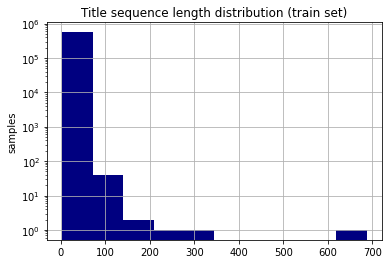

In [14]:
df_train.hist(column='clean_title_seq_length', bins = 10)
df_train_plot = df_train['clean_title_seq_length']
ax = df_train_plot.plot(kind="hist", title = 'Title sequence length distribution (train set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

In [27]:
df_train_plot.describe()

count    560622.000000
mean        293.203390
std        1451.157059
min           2.000000
25%           2.000000
50%           7.000000
75%         138.000000
max       55475.000000
Name: comments_seq_length, dtype: float64

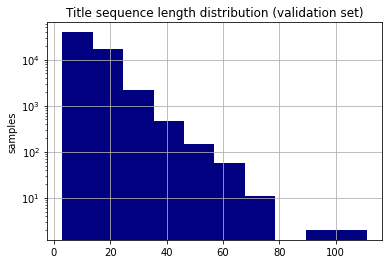

In [15]:
# df_val.hist(column='clean_title_seq_length', bins = 10)
df_val_plot = df_val['clean_title_seq_length']
ax = df_val_plot.plot(kind="hist", title = 'Title sequence length distribution (validation set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

In [26]:
df_val_plot.describe()

count    58972.000000
mean       300.293088
std       1489.062493
min          2.000000
25%          2.000000
50%          7.000000
75%        140.000000
max      39435.000000
Name: comments_seq_length, dtype: float64

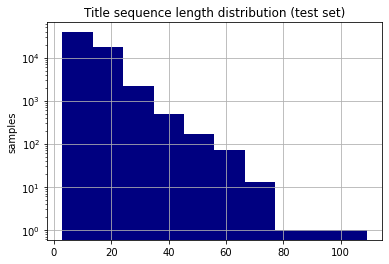

In [16]:
# df_test.hist(column='clean_title_seq_length', bins = 10)
df_test.hist(column='clean_title_seq_length', bins = 10)
df_test_plot = df_test['clean_title_seq_length']
ax = df_test_plot.plot(kind="hist", title = 'Title sequence length distribution (test set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

In [17]:
df_train.describe()

,author_enc,clean_title_seq_length,comments_seq_length,num_comments,score,hasNanScore,upvote_ratio,hasNanUpvote,2_way_label
count,560622.000000,560622.000000,560622.0,5.606220e+05,5.606220e+05,560622.000000,560622.000000,560622.000000,560622.000000
mean,146658.995394,12.068142,0.0,-1.487949e-17,2.446118e-18,0.000924,0.302425,0.298042,0.393317
std,84027.626361,7.161488,0.0,1.000001e+00,1.000001e+00,0.030383,0.853662,0.457399,0.488487
min,3.000000,3.000000,0.0,-2.179597e-01,-4.409516e-01,0.000000,-1.000000,0.000000,0.000000
25%,74025.250000,7.000000,0.0,-2.179597e-01,-1.279710e-01,0.000000,-1.000000,0.000000,0.000000
50%,147168.500000,11.000000,0.0,-1.942546e-01,-1.250215e-01,0.000000,0.800000,0.000000,0.000000
75%,222954.750000,15.000000,0.0,-1.231393e-01,-1.145342e-01,0.000000,0.920000,1.000000,1.000000
max,273237.000000,687.000000,0.0,1.163458e+01,4.482784e+01,1.000000,1.000000,1.000000,1.000000


In [18]:
df_val.describe()

,author_enc,clean_title_seq_length,comments_seq_length,num_comments,score,hasNanScore,upvote_ratio,hasNanUpvote,2_way_label
count,58972.000000,58972.000000,58972.0,58972.000000,58972.000000,58972.000000,58972.000000,58972.000000,58972.000000
mean,146370.656617,12.022248,0.0,0.004030,0.007202,0.000933,0.297314,0.300668,0.392661
std,84158.162920,7.091345,0.0,1.022123,1.071774,0.030525,0.855582,0.458552,0.488347
min,5.000000,3.000000,0.0,-0.217960,-0.167626,0.000000,-1.000000,0.000000,0.000000
25%,73038.000000,7.000000,0.0,-0.217960,-0.127971,0.000000,-1.000000,0.000000,0.000000
50%,146988.500000,11.000000,0.0,-0.194255,-0.125021,0.000000,0.800000,0.000000,0.000000
75%,222617.750000,15.000000,0.0,-0.123139,-0.114862,0.000000,0.920000,1.000000,1.000000
max,273237.000000,111.000000,0.0,11.610878,36.677890,1.000000,1.000000,1.000000,1.000000


In [19]:
df_test.describe()

,author_enc,clean_title_seq_length,comments_seq_length,num_comments,score,hasNanScore,upvote_ratio,hasNanUpvote,2_way_label
count,58954.000000,58954.000000,58954.0,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000
mean,146728.543610,12.086203,0.0,0.006278,0.007752,0.000916,0.308739,0.294891,0.396004
std,84081.239595,7.103302,0.0,1.023626,1.063737,0.030251,0.851372,0.455998,0.489069
min,13.000000,3.000000,0.0,-0.217960,-0.191878,0.000000,-1.000000,0.000000,0.000000
25%,74287.250000,7.000000,0.0,-0.217960,-0.127971,0.000000,-1.000000,0.000000,0.000000
50%,147429.500000,11.000000,0.0,-0.194255,-0.125021,0.000000,0.800000,0.000000,0.000000
75%,223100.000000,16.000000,0.0,-0.123139,-0.114206,0.000000,0.920000,1.000000,1.000000
max,273237.000000,109.000000,0.0,11.610878,35.009425,1.000000,1.000000,1.000000,1.000000


In [20]:
text_data_train_comments = FakeDetectionDataCommentsTrainVal(df_train, df_val, tokenizer, [0,1], MAX_SEQUENCE_LENGTH)

text_data_test_comments = FakeDetectionDataCommentsTest(df_test, tokenizer, [0,1], MAX_SEQUENCE_LENGTH)

560622it [32:08, 290.73it/s]
58972it [03:30, 279.52it/s]


max seq_len 55475


58954it [03:33, 275.87it/s]


max seq_len 39424


In [21]:
for row in df_train.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_train.columns, True)
    len_seq = len(text_data_train_comments.train_x[row[0]])
    df_train.at[row[0], 'comments_seq_length'] = len_seq 

for row in df_val.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_val.columns, True)
    len_seq = len(text_data_train_comments.val_x[row[0]])
    df_val.at[row[0], 'comments_seq_length'] = len_seq 

for row in df_test.itertuples(index=True, name=None):
    row_dict = convertRowToDictionary(row, df_test.columns, True)
    len_seq = len(text_data_test_comments.test_x[row[0]])
    df_test.at[row[0], 'comments_seq_length'] = len_seq 


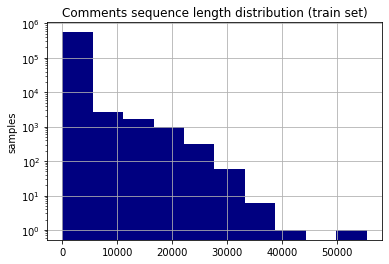

In [22]:
# df_train.hist(column='comments_seq_length', bins = 10)
df_train.hist(column='comments_seq_length', bins = 10)
df_train_plot = df_train['comments_seq_length']
ax = df_train_plot.plot(kind="hist", title = 'Comments sequence length distribution (train set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

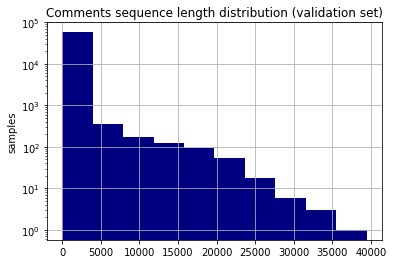

In [23]:
# df_val.hist(column='comments_seq_length', bins = 10)
df_val_plot = df_val['comments_seq_length']
ax = df_val_plot.plot(kind="hist", title = 'Comments sequence length distribution (validation set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

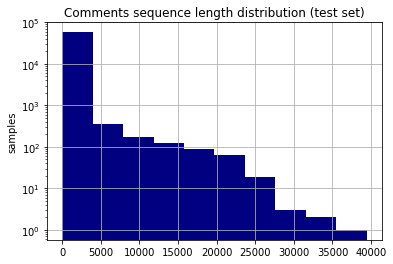

In [24]:
# df_test.hist(column='comments_seq_length', bins = 10)
df_test.hist(column='comments_seq_length', bins = 10)
df_test_plot = df_test['comments_seq_length']
ax = df_test_plot.plot(kind="hist", title = 'Comments sequence length distribution (test set)', grid=True, colormap='jet')
ax.set_ylabel("samples")
ax.set_yscale('log')

In [25]:
df_test.describe()

,author_enc,clean_title_seq_length,comments_seq_length,num_comments,score,hasNanScore,upvote_ratio,hasNanUpvote,2_way_label
count,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000,58954.000000
mean,146728.543610,12.086203,302.398226,0.006278,0.007752,0.000916,0.308739,0.294891,0.396004
std,84081.239595,7.103302,1490.108436,1.023626,1.063737,0.030251,0.851372,0.455998,0.489069
min,13.000000,3.000000,2.000000,-0.217960,-0.191878,0.000000,-1.000000,0.000000,0.000000
25%,74287.250000,7.000000,2.000000,-0.217960,-0.127971,0.000000,-1.000000,0.000000,0.000000
50%,147429.500000,11.000000,8.000000,-0.194255,-0.125021,0.000000,0.800000,0.000000,0.000000
75%,223100.000000,16.000000,142.000000,-0.123139,-0.114206,0.000000,0.920000,1.000000,1.000000
max,273237.000000,109.000000,39424.000000,11.610878,35.009425,1.000000,1.000000,1.000000,1.000000
